In [129]:
import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import spotipy
import sqlite3
from sklearn.cluster import KMeans
from sqlite3 import Error
import seaborn as sns
import matplotlib.pyplot as plt
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials
import time
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from openTSNE import TSNE as openTSNE
from wordcloud import WordCloud
from wordcloud import STOPWORDS as STOPWORDS

In [130]:
def connect_db(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    return conn

In [131]:
# connect to database
conn = connect_db('data.db')
cur = conn.cursor()

In [132]:
# Getting the target data
# Extract playlists that have the input words in their titles to use as training data
input_words = ['summer', 'beach', 'throwbacks']
# sql_select = '''SELECT AVG(danceability), AVG(energy), AVG(key), AVG(loudness), 
# AVG(mode), AVG(speechiness), AVG(acousticness), AVG(instrumentalness), AVG(liveness), 
# AVG(valence), AVG(tempo), AVG(duration_ms), AVG(time_signature) FROM avg_features_by_playlist WHERE'''

sql_select = '''SELECT * FROM avg_features_by_playlist WHERE'''
for w in range(len(input_words)):
    sql_select += " name LIKE '%" + input_words[w] + "%'"
    if w != len(input_words) -1:
        sql_select += " OR" 
pl_train = cur.execute(sql_select).fetchall()

In [133]:
# Get X data (average playlist features)
data_cols = ['pid', 'name', 'danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']
feature_cols = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']
test_cols = ['pid', 'name', 'danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']

data_rows = cur.execute('select * from avg_features_by_playlist where pid > (select MIN(pid) from avg_features_by_playlist) order by pid').fetchall()


# test_pl = cur.execute('''select tracks_in_playlist.pid, tracks_in_playlist.track_uri, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_ms, time_signature 
# from features_by_track left join tracks_in_playlist on
# features_by_track.track_uri = tracks_in_playlist.track_uri 
# where pid = (select MIN(pid) from avg_features_by_playlist)''').fetchall()


test_data = pd.DataFrame(pl_train, columns=test_cols)
data = pd.DataFrame(data_rows, columns=data_cols)

print(test_data.head())
print(data.head(5))

   pid             name  danceability    energy  key   loudness  mode  \
0    0       Throwbacks      0.664077  0.781077  0.0  -4.891212   0.0   
1  115            beach      0.658866  0.728402  0.0  -6.430356   0.0   
2  125           summer      0.677868  0.703642  0.0  -5.698415   0.0   
3  169     Summer Chill      0.646425  0.506537  0.0 -10.315649   0.0   
4  181  Summer Playlist      0.591926  0.603926  0.0  -6.992222   0.0   

   speechiness  acousticness  instrumentalness  liveness   valence  \
0     0.103698      0.083674          0.000674  0.187087  0.642750   
1     0.093119      0.166368          0.005590  0.197189  0.673794   
2     0.202636      0.139387          0.000211  0.226962  0.632208   
3     0.112705      0.350255          0.209132  0.147148  0.487011   
4     0.084893      0.161321          0.002425  0.162344  0.336756   

        tempo    duration_ms  time_signature  
0  121.157500  221777.461538        4.000000  
1  118.341402  223320.860825        3.979381  

In [134]:
conn.close()

In [135]:
# Scale the data


y = test_data[feature_cols].mean()

scaler = StandardScaler(with_mean=True, with_std=True).fit(data[feature_cols].values)

scaled_x = scaler.transform(data[feature_cols].values)
scaled_y = scaler.transform(np.array(y).reshape(1,-1))
scaled_features = pd.DataFrame(scaled_x)
tsne = openTSNE(perplexity=30, metric='euclidean', n_jobs=-1, random_state=0, verbose=False)
tsne_transformer = tsne.fit(scaled_x)
data_df = pd.DataFrame(tsne_transformer.transform(scaled_x), columns =['X', 'Y'])

print(data_df)

             X          Y
0    14.109380  -4.565597
1   -11.530071   9.845787
2    14.684081   0.976611
3     5.282314   3.440766
4   -17.079692  -2.965493
..         ...        ...
994   1.741315  -7.624736
995  -8.081646  23.130237
996 -30.256084   9.347915
997   1.851346   5.552507
998  26.002661   9.109461

[999 rows x 2 columns]


<AxesSubplot: xlabel='X', ylabel='Y'>

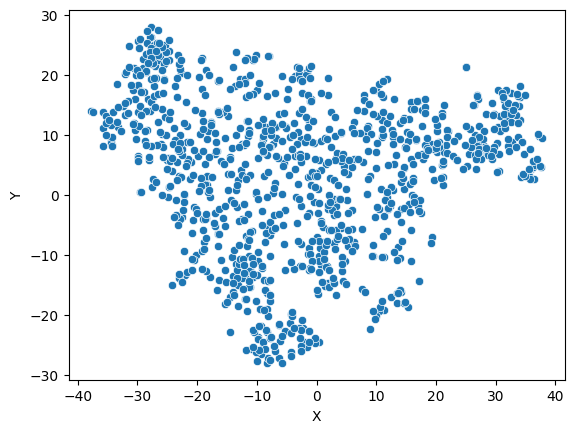

In [136]:
sns.scatterplot(x='X', y='Y', data=data_df, legend=None)

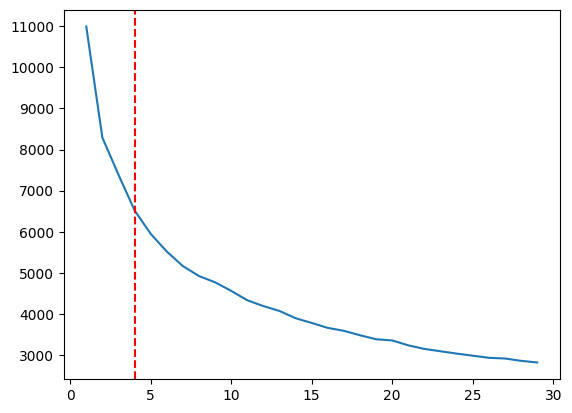

In [137]:
#TODO:
# needs to be tested and K updated below
#calculate how many K clusters there should be 
wcss = [] 
for number_of_clusters in range(1, 30): 
    kmeans = KMeans(n_clusters = number_of_clusters, random_state = 42)
    kmeans.fit(scaled_x) 
    wcss.append(kmeans.inertia_)
wcss

ks = range(1, 30)
plt.plot(ks, wcss)
plt.axvline(4, linestyle='--', color='r')

In [138]:
# initialize KMeans
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit(scaled_x)
labels = clusters.labels_
data_df['cluster'] = pd.Categorical(labels)

target_cluster = kmeans.predict(scaled_y)
print(target_cluster)

[15]


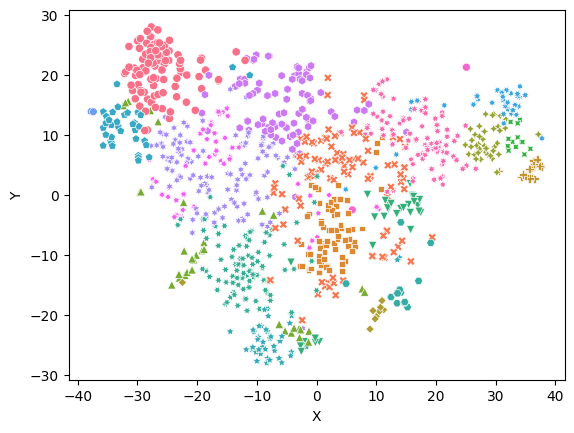

In [139]:
sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=data_df, legend=None)
plt.show()

In [ ]:
data_df["playlist_name"] = data['name'].str.lower()
# display(data_df)

# we want to perform a pivot on data_df so that each cluster number is a column with row value equal to the playlist name.
# from there we can sum up that column to get the whole lsit of strings of playlist names for each cluster (column)
original_df = data_df.pivot(index='X', columns='cluster')['playlist_name'].reset_index()
original_df.columns.name = None
original_df = original_df.fillna('')
# original_df.head(20)
# print(original_df.columns)

#list of words to ignore
stop_words = STOPWORDS.update(["i", "it", "me", "my", "that", "the", "of", "than", "then", 
"when", "if", "a", "there", "playlist", "music", "song", "songs", "to", "too", "get", "as", "this", 
"am", "is", "are", "has", "and", "aa", "aaa", 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 
'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])

wordclouds = {}
for i in range(n_clusters):
    original_df.replace(np.nan, '')
    original_df[i] = original_df[i].astype(str) #.sum(skipna=True))
    wordclouds["wordcloud" + str(i)] = WordCloud(stopwords=stop_words).generate(' '.join(original_df[i]))

for val in wordclouds.values():
    plt.imshow(val)
    plt.axis("off")
    plt.show()

In [148]:
def get_target_cluster_songs(target_cluster):
    data_df["pid"] = data['pid']
    original_df = data_df.pivot(columns='cluster', values='pid')
    target_cluster_df = original_df[[target_cluster]].dropna()
    conn = connect_db('data.db')
    cur = conn.cursor()
    sql = '''SELECT features_by_track.* FROM features_by_track join tracks_in_playlist on features_by_track.track_uri = tracks_in_playlist.track_uri
        WHERE '''
    for pid in target_cluster_df[target_cluster].values:
        sql += "tracks_in_playlist.pid = " + str(int(pid))
        sql += " OR "
    sql = sql[:-3]
    cols = ["track_uri",
        "danceability",
        "energy",
        "key",
        "loudness",
        "mode",
        "speechiness",
        "acousticness",
        "instrumentalness",
        "liveness",
        "valence",
        "tempo",
        "duration_ms",
        "time_signature"]
        
    result = cur.execute(sql).fetchall()
    
    conn.close()
    tracks = pd.DataFrame(result, columns = cols)
    tracks = tracks[tracks['track_uri'].map(tracks['track_uri'].value_counts()) > 3]
    
    tracks['counts'] = tracks.groupby(['track_uri'])['time_signature'].transform('count')
    
    tracks = tracks.drop_duplicates(subset=['track_uri'])
    song_instances = tracks['counts'].sum()

    
    #num_unique_songs = len(pd.unique(tracks['track_uri']))
    print(song_instances, " song instances fetched")
    print(len(tracks), " unique songs fetched")
    print(tracks.head(5))
    return tracks
    

In [149]:
target_cluster_songs = get_target_cluster_songs(target_cluster[0])

3410  song instances fetched
522  unique songs fetched
                 track_uri  danceability  energy   key  loudness  mode  \
65  5Q0Nhxo0l2bP3pNjpGJwV1         0.652   0.698  10.0    -4.667   0.0   
66  1V4jC0vJ5525lEF1bFgPX2         0.825   0.856   1.0    -1.912   1.0   
69  0CAfXk7DXMnon4gLudAp7J         0.918   0.609  10.0    -5.640   0.0   
71  4Ow5x7P5NAAR1jPoskudoA         0.781   0.745   4.0    -5.810   0.0   
74  0XUfyU2QviPAs6bxSpXYG4         0.881   0.788   2.0    -4.669   1.0   

    speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
65       0.0420       0.00112          0.000115    0.0886    0.470   96.021   
66       0.0476       0.00851          0.000001    0.1270    0.207  128.016   
69       0.0791       0.09280          0.000000    0.1390    0.304  128.008   
71       0.0332       0.19800          0.000011    0.3600    0.326  129.998   
74       0.1680       0.02120          0.000000    0.0377    0.592  104.997   

    duration_ms  time_sig

In [165]:
target_cluster_songs

,track_uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,counts
65,5Q0Nhxo0l2bP3pNjpGJwV1,0.652,0.698,10.0,-4.667,0.0,0.0420,0.00112,0.000115,0.0886,0.470,96.021,202067,4,14
66,1V4jC0vJ5525lEF1bFgPX2,0.825,0.856,1.0,-1.912,1.0,0.0476,0.00851,0.000001,0.1270,0.207,128.016,222133,4,6
69,0CAfXk7DXMnon4gLudAp7J,0.918,0.609,10.0,-5.640,0.0,0.0791,0.09280,0.000000,0.1390,0.304,128.008,231400,4,13
71,4Ow5x7P5NAAR1jPoskudoA,0.781,0.745,4.0,-5.810,0.0,0.0332,0.19800,0.000011,0.3600,0.326,129.998,269493,4,5
74,0XUfyU2QviPAs6bxSpXYG4,0.881,0.788,2.0,-4.669,1.0,0.1680,0.02120,0.000000,0.0377,0.592,104.997,250373,4,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4998,5zBqPjh3vfttJScml99szD,0.816,0.561,1.0,-7.702,0.0,0.3160,0.13600,0.000008,0.1690,0.449,80.460,241200,4,4
5067,1UZ25gykR30Oewh3dBRtVZ,0.573,0.495,8.0,-7.245,0.0,0.5920,0.40500,0.000000,0.0969,0.255,179.196,312027,3,4
5339,0ADG9OgdVTL7fgREP75BrZ,0.576,0.782,6.0,-4.825,0.0,0.0296,0.00778,0.000000,0.2850,0.355,141.153,224031,4,5
5432,0CcQNd8CINkwQfe1RDtGV6,0.779,0.787,10.0,-4.305,0.0,0.1080,0.05240,0.000000,0.1400,0.708,124.982,204347,4,5


In [150]:
feature_cols.append('counts')
scaler_song = StandardScaler(with_mean=True, with_std=True).fit(target_cluster_songs[feature_cols].values)

scaled_song_x = scaler_song.transform(target_cluster_songs[feature_cols].values)
scaled_song_features = pd.DataFrame(scaled_song_x)
tsne_song = openTSNE(perplexity=30, metric='euclidean', n_jobs=-1, random_state=0, verbose=False)
tsne_transformer_song = tsne_song.fit(scaled_song_x)
song_data_df = pd.DataFrame(tsne_transformer_song.transform(scaled_song_x), columns =['X', 'Y'])

print(song_data_df)

             X          Y
0    14.890893 -18.347256
1    12.429821   5.121351
2    16.442862 -16.222516
3   -17.555520   2.168596
4    11.510838 -16.778778
..         ...        ...
517  -2.595894   0.251128
518  -0.773699  11.632445
519 -13.116566  -0.941457
520 -11.177420  -6.135580
521   4.820180  -2.990858

[522 rows x 2 columns]


In [142]:
def get_song_target_cluster_songs(target_cluster):
    song_data_df["track_uri"] = target_cluster_songs['track_uri']
    original_df = song_data_df.pivot(columns='cluster', values='track_uri')
    target_cluster_df = original_df[[target_cluster]].dropna()
    
    conn = connect_db('data.db')
    cur = conn.cursor()
    sql = "SELECT track_name, track_uri FROM tracks WHERE "
    for uri in target_cluster_df[target_cluster].values:
        sql += "track_uri = " + "\"" + uri + "\""
        sql += " OR "
    sql = sql[:-3]
    cols = ["track_name", "track_uri"]
    
    result = cur.execute(sql).fetchall()
    conn.close()

    tracks = pd.DataFrame(result, columns = cols)

    unique_songs = pd.unique(tracks['track_uri'])
    print(len(unique_songs), " songs fetched")
    print(unique_songs)
    return unique_songs

In [143]:
def connect_to_spotify():
    # Spotify credentials
    cid = "5cffc2676cd44b35bc6af81faeb8e69a"
    secret = "f9fdae88362349b992ab2714ea91a094"
    os.environ["SPOTIPY_CLIENT_ID"] = cid
    os.environ["SPOTIPY_CLIENT_SECRET"] = secret
    os.environ['SPOTIPY_REDIRECT_URI'] = "http://127.0.0.1:8080"
    client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
    sp = spotipy.Spotify(client_credentials_manager = SpotifyClientCredentials())

    return sp

In [144]:
sp = connect_to_spotify()

In [178]:
import spotipy.util as util

#must give a list of track ids, must include "spotify:track:"
user_id = "1a0f1b9085db4f49"
username = "31y7j5k3jeidd5rzhaznsdregg34"
playlistName = ""
scope = "playlist-modify-public"
songs_to_add = []
c = 0
for i in input_words:
    playlistName += input_words[c] + " "
    c += 1
    
results = target_cluster_songs['track_uri']
results = results.values.tolist()
c = 0
for track in range(99):
    songs_to_add.append("spotify:track:" + results[c])
    c += 1

token = SpotifyOAuth(scope = scope, username = username)
if token:
    sp = spotipy.Spotify(auth_manager=token)
    sp.user_playlist_create(user = username, name = playlistName)
    prep = sp.user_playlists(user = username)
    playlist = prep['items'][0]['id']
    sp.user_playlist_add_tracks(user = username, playlist_id= playlist, tracks=songs_to_add)
else:
    print("Can't get token for", username)
